In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model, Sequential
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Conv2DTranspose,\
                                    Reshape, ReLU, LeakyReLU,BatchNormalization, Lambda, \
                                    UpSampling2D, Softmax, Input, Dropout, AvgPool2D, Concatenate, \
                                    LocallyConnected2D, SpatialDropout2D, Activation, InputLayer, \
                                    GaussianNoise
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
tf.__version__

'2.0.0'

In [3]:
from VisionEngine.data import butterflies

In [4]:
(real_images, real_classes), (_, _) = butterflies.load_data(path='../data/raw/butterflies.npz')
(generated_images, genertaed_classes), (_, _) = butterflies.load_data(path='../data/raw/generated_butterflies.npz')

In [13]:
images = np.concatenate([real_images, generated_images])
images = images.astype('float32')

In [14]:
images.shape

(4391, 256, 256, 3)

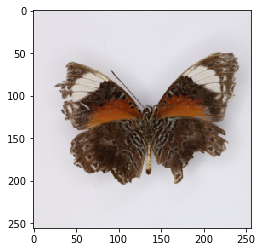

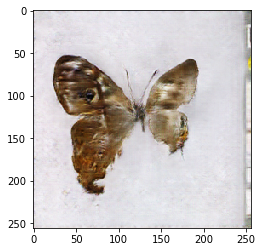

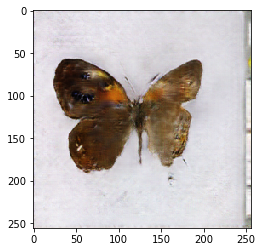

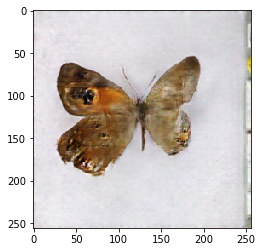

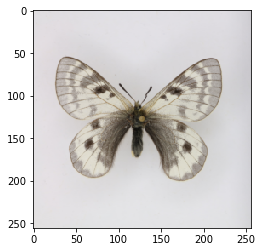

In [15]:
for i in np.random.randint(0,  len(images)-1, 5):
    plt.imshow(images[i])
    plt.show()

In [16]:
tf.keras.backend.clear_session()
gc.collect()

2359

In [17]:
class SaltAndPepper(tf.keras.layers.Layer):

    def __init__(self, ratio=0.9, **kwargs):
        super(SaltAndPepper, self).__init__(**kwargs)
        self.supports_masking = True
        self.ratio = ratio

    def call(self, inputs, training=None):
        def noised():
            shp = K.shape(inputs)[1:]
            mask_select = K.random_binomial(shape=shp, p=self.ratio)
            mask_noise = K.random_binomial(shape=shp, p=0.1) # salt and pepper have the same chance
            out = (inputs * (mask_select)) + mask_noise
            return out

        return K.in_train_phase(noised(), inputs, training=training)

    def get_config(self):
        config = {'ratio': self.ratio,
                  'supports_masking': self.supports_masking}
        base_config = super(SaltAndPepper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [18]:
class NormalVariational(tf.keras.layers.Layer):
    
    def __init__(self, size, mu_prior=0., sigma_prior=1., add_gmm=False, n_mixtures=None, add_kl=False, coef_kl=1.0, add_mmd=True, lambda_mmd=1.0, kernel_f=None, name=None):
        super().__init__(name=name)
        self.mu_layer = tf.keras.layers.Dense(size)
        self.sigma_layer = tf.keras.layers.Dense(size)
        self.mu_prior = tf.constant(mu_prior, dtype=tf.float32, shape=(size,))
        self.sigma_prior = tf.constant(sigma_prior, dtype=tf.float32, shape=(size,))

        self.add_kl = add_kl
        self.coef_kl = tf.Variable(coef_kl, trainable=False, name='coef_kl')

        self.add_mmd = add_mmd
        self.lambda_mmd = lambda_mmd
        if kernel_f is None:
            self.kernel_f = self._rbf
        else:
            self.kernel_f = kernel_f

        self.add_gmm = add_gmm
        self.n_mixtures = n_mixtures
        if self.n_mixtures:
            self.mu_layers = [tf.keras.layers.Dense(size) for i in range(n_mixture)]
            self.sigma_layers = [tf.keras.layers.Dense(size) for i in range(n_mixtures)]
            self.mu_priors = [tf.constant(mu_prior, dtype=tf.float32, shape=(size,)) for i in range(n_mixture)]
            self.sigma_priors = [tf.constant(sigma_prior, dtype=tf.float32, shape=(size,)) for i in range(n_mixture)]
            
    def _rbf(self, x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
        tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

    def add_kl_divergence(self, q_mu, q_sigma, p_mu, p_sigma):
        r = q_mu - p_mu
        kl = tf.reduce_mean(self.coef_kl * tf.reduce_sum(tf.math.log(p_sigma) - tf.math.log(q_sigma) - .5 * (1. - (q_sigma**2 + r**2) / p_sigma**2), axis=1))
        self.add_loss(kl)
        self.add_metric(kl, 'mean', 'kl_divergence')

    def add_mm_discrepancy(self, z, z_prior):
        k_prior = self.kernel_f(z_prior, z_prior)
        k_post = self.kernel_f(z, z)
        k_prior_post = self.kernel_f(z_prior, z)
        mmd = tf.reduce_mean(k_prior) + tf.reduce_mean(k_post) - 2 * tf.reduce_mean(k_prior_post)
        mmd = tf.multiply(self.lambda_mmd,  mmd, name='mmd')
        self.add_loss(mmd)
        self.add_metric(mmd, 'mean', 'mmd_discrepancy')

    def add_gmm_log_prob(self, z):
        gmm_loss = - tf.reduce_mean(self.mixture_model.log_prob(z))
        self.add_loss(gmm_loss)
        self.add_metric(gmm_loss, 'mean', 'gmm_log_prob')

    def call(self, inputs):
        if self.add_mmd:
            mu = self.mu_layer(inputs)
            log_sigma =  self.sigma_layer(inputs)
            sigma_square = tf.exp(log_sigma)
            z = mu + sigma_square * tf.random.normal(tf.shape(sigma_square))
            z_prior = tfp.distributions.MultivariateNormalDiag(self.mu_prior, self.sigma_prior).sample(tf.shape(z)[0])
            self.add_mm_discrepancy(z, z_prior)

        if self.add_kl:
            mu = self.mu_layer(inputs)
            log_sigma =  self.sigma_layer(inputs)
            sigma_square = tf.exp(log_sigma)
            self.add_kl_divergence(mu, sigma_square, self.mu_prior, self.sigma_prior)
        
        if self.add_gmm:
            probs = tf.Variable(shape=[n_mixtures], dtype=tf.float32, name='mixture_probs')
            probs = tf.nn.softmax(probs)
            scale_fn = lambda name: tf.nn.softplus(tf.Variable(np.ones([size], dtype='float32'), name=name))
            self.mixture_model = tf.distributions.MixtureSameFamily(
                mixture_distribution=tf.distributions.Categorical(probs=probs),
                components_distribution=tf.distributions.MultivariateNormalDiag(
                        loc=[tf.Variabel(shape=[size], name='loc{}'.format(i)) for i in range(n_mixtures)],
                        scale_identity_multiplier=[scale_fn('scale{}'.format(i)) for i in range(n_mixtures)]
                    )
            )
            mus = [mu_layer(inputs) for mu_layer in self.mu_layers]
            log_sigmas = [sigma_layer(inputs) for sigma_layer in self.sigma_layers]
            sigma_squares = tf.exp(log_sigma)
            z = mus + sigma_squares * tf.random.normal(tf.shape(sigma_square))
            self.add_gmm_log_prob(z)

        return z

    def get_config(self):
        base_config = super(NormalVariational, self).get_config()
        config = {
            'add_kl': self.add_kl,
            'add_mmd': self.add_mmd,
            'lambda_mmd': self.lambda_mmd,
            'add_gmm': self.add_gmm,
            'n_mixtures': self.n_mixtures,
        }
        return dict(list(base_config.items()) + list(config.items()))

In [19]:
def make_encoder(latent_size):
    
    inputs = Input((256,256,3))
    with tf.name_scope('noise'):
        noise_layers = Sequential([
            SaltAndPepper(),
            GaussianNoise(0.1)
            ], name='noise')
        noisy_inputs = noise_layers(inputs)

    with tf.name_scope('h_1'):
        h_1_layers = Sequential([ 
            Input((256, 256, 3)),
            Conv2D(64, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(64, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_1')
        h_1 = h_1_layers(noisy_inputs)
        h_1_flatten = Flatten()(h_1)

    with tf.name_scope('h_2'):
        h_2_layers = Sequential([ 
            Conv2D(128, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(128, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(256, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_2')
        h_2 = h_2_layers(h_1)
        h_2_flatten = Flatten()(h_2)

    with tf.name_scope('h_3'):
        h_3_layers = Sequential([ 
            Conv2D(256, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(512, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(512, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_3')
        h_3 = h_3_layers(h_2)
        h_3_flatten = Flatten()(h_3)

    with tf.name_scope('h_4'):
        h_4_layers = Sequential([ 
            Dense(1024, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Dense(1024, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_4')
        h_4 = h_4_layers(h_3)
        h_4_flatten = Flatten()(h_4)

    return Model(inputs, [h_1_flatten, h_2_flatten, h_3_flatten, h_4_flatten], name='encoder')

In [20]:
def make_decoder(latent_dim1, latent_dim2, latent_dim3, latent_dim4):
    z_1_input, z_2_input, z_3_input, z_4_input = Input((latent_dim1,), name='z_1'), Input((latent_dim2,), name='z_2'), Input((latent_dim3,), name='z_3'), Input((latent_dim4,), name='z_4')
    
    with tf.name_scope('z_tilde_4'):
        z_4 = z_4_input
        z_tilde_4_layers = Sequential([
            Dense(1024, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Dense(1024, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Dense(16*16*512, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Reshape((16,16,512))], name='z_tilde_4')
        z_tilde_4 = z_tilde_4_layers(z_4)

    with tf.name_scope('z_tilde_3'):
        z_3 = Dense(16*16*512, kernel_regularizer=l2(2.5e-5))(z_3_input)
        z_3 = BatchNormalization()(z_3)
        z_3 = ReLU()(z_3)
        z_3 = Reshape((16,16,512))(z_3)
        z_tilde_3_layers = Sequential([
            Conv2DTranspose(512, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(256, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(256, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU()], name='z_tilde_3')
        input_z_tilde_3 = Concatenate()([z_tilde_4, z_3])
        z_tilde_3 = z_tilde_3_layers(input_z_tilde_3)
        
    with tf.name_scope('z_tilde_2'):
        z_2 = Dense(32*32*256, kernel_regularizer=l2(2.5e-5))(z_2_input)
        z_2 = BatchNormalization()(z_2)
        z_2 = ReLU()(z_2)
        z_2 = Reshape((32,32,256))(z_2)
        z_tilde_2_layers = Sequential([
            Conv2DTranspose(128, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(128, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(64, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU()], name='z_tilde_2')
        input_z_tilde_2 = Concatenate()([z_tilde_3, z_2])
        z_tilde_2 =  z_tilde_2_layers(input_z_tilde_2)
    
    with tf.name_scope('z_tilde_1'):
        z_1 = Dense(128*128*64, kernel_regularizer=l2(2.5e-5))(z_1_input)
        z_1 = BatchNormalization()(z_1)
        z_1 = ReLU()(z_1)
        z_1 = Reshape((128,128,64))(z_1)
        z_tilde_1_layers = Sequential([
            Conv2DTranspose(128, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            Conv2DTranspose(3, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            Activation('sigmoid')], name='z_tilde_1')
        input_z_tilde_1 = Concatenate()([z_tilde_2, z_1])
        decoder =  z_tilde_1_layers(input_z_tilde_1)

    return Model([z_1_input, z_2_input, z_3_input, z_4_input], decoder, name='decoder')

In [21]:
def make_vlae(latent_size, use_perceptual_loss=False):
    with tf.name_scope('encoder'):
        encoder = make_encoder(latent_size)
    with tf.name_scope('decoder'):
        decoder = make_decoder(latent_size, latent_size, latent_size, latent_size)
    inputs = Input((256,256,3))
    h_1, h_2, h_3, h_4 = encoder(inputs)
    z_1 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_1_latent')(h_1)
    z_2 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_2_latent')(h_2)
    z_3 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_3_latent')(h_3)
    z_4 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_4_latent')(h_4)
    decoded = decoder([z_1, z_2, z_3, z_4])
    vlae = Model(inputs, decoded, name='vlae')
    return vlae

In [22]:
class KLWarmUp(tf.keras.callbacks.Callback):
    
    def __init__(self, vlae, n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
        self.frange = frange_cycle_linear(n_iter, start=start, stop=stop,  n_cycle=n_cycle, ratio=ratio)
        self.vlae = vlae
        self.epoch = 0
        
        
    def on_epoch_end(self, *args, **kwargs):
        new_coef = self.frange[self.epoch]
        self.epoch += 1
        coefs = [self.vlae.get_layer(f'z_{i+1}_latent').coef_kl for i in range(3)]
        for coef in coefs:
            coef.assign(new_coef)
    
    @staticmethod
    def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
        L = np.ones(n_iter) * stop
        period = n_iter/n_cycle
        step = (stop-start)/(period*ratio) # linear schedule

        for c in range(n_cycle):
            v, i = start, 0
            while v <= stop and (int(i+c*period) < n_iter):
                L[int(i+c*period)] = v
                v += step
                i += 1
        return L 

In [23]:
latent_size = 10

In [24]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir ../logs

Reusing TensorBoard on port 6006 (pid 15428), started 0:39:08 ago. (Use '!kill 15428' to kill it.)

In [25]:
vlae = make_vlae(latent_size)

In [26]:
epochs = 500
tb = TensorBoard(write_images=False, write_graph=True, histogram_freq=25)
es = EarlyStopping(min_delta=0.0001, patience=15)
# klwarmup = KLWarmUp(vlae, epochs)
lr_epochs = 10 ** np.linspace(-5, -8, epochs)
lrsched = LearningRateScheduler(lambda i: lr_epochs[i])

In [27]:
vlae.summary()

Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 984064), (No 9918848     input_3[0][0]                    
__________________________________________________________________________________________________
z_1_latent (NormalVariational)  (None, 10)           19681301    encoder[1][0]                    
__________________________________________________________________________________________________
z_2_latent (NormalVariational)  (None, 10)           4014101     encoder[1][1]                    
_______________________________________________________________________________________________

In [6]:
def custom_loss(x, xhat):
        return  .5 * tf.losses.mean_squared_error(tf.keras.layers.Flatten()(x), tf.keras.layers.Flatten()(xhat)) * np.prod([256,256,3])

In [30]:
vlae.compile(tf.keras.optimizers.Adam(), custom_loss)

In [31]:
vlae.fit(images, images, validation_split=0.05, batch_size=20, epochs=epochs, callbacks=[tb, lrsched])

Train on 4171 samples, validate on 220 samples
Epoch 1/500
4171/4171 [==============================] - 98s 23ms/sample - loss: 7611.8522 - mmd_discrepancy: 486.5113 - val_loss: 4754.1353 - val_mmd_discrepancy: 333.7225
Epoch 2/500
4171/4171 [==============================] - 77s 18ms/sample - loss: 3614.6648 - mmd_discrepancy: 402.4694 - val_loss: 4691.5182 - val_mmd_discrepancy: 646.5596
Epoch 3/500
4171/4171 [==============================] - 77s 18ms/sample - loss: 3082.9409 - mmd_discrepancy: 314.1430 - val_loss: 4359.5342 - val_mmd_discrepancy: 1085.3917
Epoch 4/500
4171/4171 [==============================] - 77s 18ms/sample - loss: 2702.1732 - mmd_discrepancy: 228.8329 - val_loss: 4577.5088 - val_mmd_discrepancy: 1094.6421
Epoch 5/500
4171/4171 [==============================] - 77s 18ms/sample - loss: 2364.9413 - mmd_discrepancy: 178.3438 - val_loss: 3711.1239 - val_mmd_discrepancy: 1063.3329
Epoch 6/500
4171/4171 [==============================] - 77s 19ms/sample - loss: 2282

Epoch 96/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 671.1939 - mmd_discrepancy: 65.5234 - val_loss: 2044.3259 - val_mmd_discrepancy: 660.8246
Epoch 97/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 680.4851 - mmd_discrepancy: 65.9454 - val_loss: 1717.7858 - val_mmd_discrepancy: 570.2712
Epoch 98/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 652.5647 - mmd_discrepancy: 65.4510 - val_loss: 1778.0038 - val_mmd_discrepancy: 556.5203
Epoch 99/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 657.6622 - mmd_discrepancy: 64.4909 - val_loss: 1688.7019 - val_mmd_discrepancy: 566.2540
Epoch 100/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 669.1180 - mmd_discrepancy: 67.4082 - val_loss: 1805.6976 - val_mmd_discrepancy: 559.2005
Epoch 101/500
4171/4171 [==============================] - 88s 21ms/sample - loss: 695.5578 - mmd_discrepancy: 68.3228 - val_loss: 1910.465

4171/4171 [==============================] - 78s 19ms/sample - loss: 526.7461 - mmd_discrepancy: 60.6758 - val_loss: 1750.7185 - val_mmd_discrepancy: 499.9062
Epoch 191/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 528.3875 - mmd_discrepancy: 63.1681 - val_loss: 1913.3490 - val_mmd_discrepancy: 600.2700
Epoch 192/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 525.2762 - mmd_discrepancy: 60.8258 - val_loss: 1849.2836 - val_mmd_discrepancy: 572.6016
Epoch 193/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 518.5846 - mmd_discrepancy: 59.6483 - val_loss: 1797.6934 - val_mmd_discrepancy: 549.1959
Epoch 194/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 521.5066 - mmd_discrepancy: 58.4935 - val_loss: 1748.6804 - val_mmd_discrepancy: 518.1016
Epoch 195/500
4171/4171 [==============================] - 78s 19ms/sample - loss: 529.0045 - mmd_discrepancy: 62.6879 - val_loss: 1768.3652 - val_mm

KeyboardInterrupt: 

In [32]:
tf.saved_model.save(vlae, '../checkpoints/vlae_butterflies')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../checkpoints/vlae_butterflies/assets


In [7]:
vlae = tf.keras.models.load_model('../checkpoints/vlae_butterflies', custom_objects={'loss': custom_loss}, compile=False)
vlae.compile()

In [ ]:
# plt.style.use('classic')
plt.rcParams.update({'font.size': 30})

In [40]:
h_0 = []
h_1 = []
h_2 = []
h_3 = []
for image in generated_images:
    x = vlae.get_layer('encoder').predict(np.expand_dims(image, axis=0));
    h_0.append(vlae.get_layer('z_1_latent')(x[0]))
    h_1.append(vlae.get_layer('z_2_latent')(x[1]))
    h_2.append(vlae.get_layer('z_3_latent')(x[2]))
    h_3.append(vlae.get_layer('z_4_latent')(x[3]))


In [43]:

h_3 = np.array(h_3)
h_3 = h_3.reshape(generated_images.shape[0],latent_size)

h_2 = np.array(h_2)
h_2 = h_2.reshape(generated_images.shape[0],latent_size)

h_1 = np.array(h_1)
h_1 = h_1.reshape(generated_images.shape[0],latent_size)

h_0 = np.array(h_0)
h_0 = h_0.reshape(generated_images.shape[0],latent_size)

In [8]:
image_output_folder = '/home/etheredge/Workspace/VisionEngine/report/figures/images'
n_latents = 4 
latent_size = 10

In [9]:
def make_rand_samples(model, n_samples=9, num_steps=300, mu=0, sigma=1):
    output_folder = os.path.join(image_output_folder, 'explore_latents/random_normal/frames_bflies')
    
    sample =  [
        np.random.multivariate_normal([mu] * latent_size,np.diag([sigma] * latent_size), n_samples)
        ] * n_latents

    for z in range(n_latents):
        for t in range(num_steps):
            sample[z] = np.random.multivariate_normal(
                [mu] * latent_size, np.diag([sigma] * latent_size), n_samples)
            generated = model.get_layer('decoder').predict(sample, batch_size=10)
            generated = generated.reshape((n_samples, 256, 256,3))
            image_container = Image.new('RGB', (256*3,256*3))
            locs = list(product(range(int(np.sqrt(n_samples))),range(int(np.sqrt(n_samples)))))
            for i in range(n_samples):
                img = generated[i]
                j, k = locs[i]
                img = 255 * np.array(img)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (k*256, j*256))
            image_container.save(os.path.join(output_folder,'z{}_{:03d}.jpg'.format(z,t)))


def make_traversal_from_zeros(model, n_samples=1, num_steps=11):
    output_folder = os.path.join(image_output_folder, 'explore_latents/traversal_bflies')

    multipliers = np.linspace(-2,2,num=num_steps)

    for z_i in range(4):
        image_container = Image.new('RGB', (256*num_steps,256*latent_size))
        for z_i_j in range(latent_size):
            for s in range(num_steps):
                sample = [np.array([[0] * latent_size]),
                        np.array([[0] * latent_size]),
                        np.array([[0] * latent_size]),
                        np.array([[0] * latent_size])]
                
                sample[z_i][0][z_i_j] = multipliers[s]
                generated = model.get_layer('decoder').predict(sample, batch_size=1)
                generated = generated.reshape((256, 256,3))
                img = 255 * np.array(generated)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (s*256, z_i_j*256))
        image_container.save(os.path.join(output_folder,'z{}.jpg'.format(z_i)))


def make_traversal_from_sample(model, z, n_samples=1, num_steps=11, sample_id=0):
    output_folder = os.path.join(image_output_folder, 'explore_latents/traversal_bflies')

    multipliers = np.linspace(-2,2,num=num_steps)
    encoded_sample = [z_i[sample_id] for z_i in z]

    for z_i in range(4):
        image_container = Image.new('RGB', (256*num_steps,256*latent_size))
        for z_i_j in range(latent_size):
            for s in range(num_steps):
                sample = [np.array([encoded_sample[0].numpy()]),
                      np.array([encoded_sample[1].numpy()]),
                      np.array([encoded_sample[2].numpy()]),
                      np.array([encoded_sample[3].numpy()])]
                
                sample[z_i][0][z_i_j] = multipliers[s]
                generated = model.get_layer('decoder').predict(sample, batch_size=1)
                generated = generated.reshape((256, 256,3))
                img = 255 * np.array(generated)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (s*256, z_i_j*256))
        image_container.save(os.path.join(output_folder,'{}sample{}.jpg'.format(sample_id, z_i)))


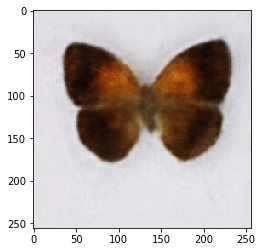

In [34]:
plt.imshow(x_hat[8])

In [35]:
make_rand_samples(vlae)
make_traversal_from_zeros(vlae)
make_traversal_from_sample(vlae, z, sample_id=8)

In [10]:
import math
from PIL import Image
from itertools import product

In [11]:
def sample_likelihood(x, x_hat):
        mse = - tf.losses.mean_squared_error(Flatten()(x), Flatten()(x_hat))
        return 1./(tf.sqrt(2.*math.pi))*tf.exp(-.5*(mse)**2.)

def embed_images(x):
    x = vlae.get_layer('encoder').predict(x, batch_size=10)
    return [vlae.get_layer('z_1_latent')(x[0]), 
            vlae.get_layer('z_2_latent')(x[1]),
            vlae.get_layer('z_3_latent')(x[2]),
            vlae.get_layer('z_4_latent')(x[3])]

def reconstruct_images(z):
    return vlae.get_layer('decoder').predict(z)

with tf.device("GPU:0"):
        z = embed_images(real_images)
        x_hat = reconstruct_images(z)
        likelihood = sample_likelihood(real_images, x_hat)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [44]:
np.save('bflies_h_0g', h_0)
np.save('bflies_h_1g', h_1)
np.save('bflies_h_2g', h_2)
np.save('bflies_h_3g', h_3)

In [ ]:

embedding = TSNE().fit(Z)

In [3]:
import matplotlib as mpl
from openTSNE import TSNE
import itertools
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use('classic')
plt.rcParams.update({'font.size': 30})

In [10]:
latent_size =10

In [11]:

h_3 = np.array(h_3)
h_3 = h_3.reshape(gan_images.shape[0],latent_size)

h_2 = np.array(h_2)
h_2 = h_2.reshape(gan_images.shape[0],latent_size)

h_1 = np.array(h_1)
h_1 = h_1.reshape(gan_images.shape[0],latent_size)

h_0 = np.array(h_0)
h_0 = h_0.reshape(gan_images.shape[0],latent_size)

In [ ]:
fig = plt.figure(figsize=(20,20))
Y = np.array(real_labels)
classnames, indices = np.unique(Y, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=150)

In [ ]:
fig = plt.figure(figsize=(100,25))
for i, h in enumerate([h_0, h_1, h_2, h_3]):
    ax = plt.subplot(1,4,i+1,sharex, sharey='all')
    embedding = TSNE(n_components=2).fit_transform(Z)
    scatter = imscatter(embedding[:, 0], embedding[:, 1], gan_images, zoom=0.1, ax=ax)
    ax.set_title('Level {}'.format(i+1))
fig = plt.gcf()
fig.savefig('reports/figures/panels/vlae_embedding_gan_images.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)

In [21]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use('classic')
plt.rcParams.update({'font.size': 30})

# Z = h_3
# reducer = umap.UMAP(random_state=2, n_neighbors=30)
# embedding = reducer.fit_transform(Z)
# embedding = TSNE(n_components=2).fit_transform(Z)
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca();
    try:
        image = plt.imread(image);
    except TypeError:
        # Likely already an array...
        pass
    x, y = np.atleast_1d(x, y);
    artists = [];
    for i, (x0, y0) in enumerate(zip(x, y)):
        im = OffsetImage(image[i], zoom=zoom);
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False);
        artists.append(ax.add_artist(ab));
    ax.update_datalim(np.column_stack([x, y]));
    ax.autoscale();
    ax.grid(False);
    return artists
# fig, ax = plt.subplots(figsize=(100,25));
# imscatter(embedding[:, 0], embedding[:, 1], real_images, zoom=0.1, ax=ax);

In [ ]:
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z


In [ ]:
L = brooks_attrs[:,1]
# Z = np.concatenate([h_0, h_1, h_2, h_3],axis=1)
Z = h_3
# Z = attrs[:,2:]
# reducer = umap.UMAP(random_state=2)
reducer = PCA(n_components=2)
embedding = reducer.fit_transform(Z)
x = embedding[:, 0]
y = embedding[:, 1]
z = L
m = polyfit2d(x, y, z)
nx, ny = 20, 20
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx), 
                     np.linspace(y.min(), y.max(), ny))
zz = polyval2d(xx, yy, m)

plt.scatter(x, y, c=z)
plt.imshow(zz, extent=(x.min(), y.max(), x.max(), y.min()))

plt.show()

# Future improvements
* Use the label as additional information to improve the recostruction